In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import plotly.graph_objects as go
import neurokit2 as nk
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
from datetime import datetime, timezone, timedelta
from scipy.signal import resample_poly
from pyedflib.highlevel import read_edf
from zoneinfo import ZoneInfo
from wrangle import *
from time_loader import *

# Set Session Directory
Checks for the correct data in selected directory

In [2]:
required_files = [
        'CSV.csv',
        'EDF.edf',
        'BVP.csv',
        'EDA.csv',
        'ACC.csv',
        'TEMP.csv',
        'tags.csv',
        'IBI.csv'
    ]
dataDirectory = "C:/home/Sessions/P009/"
participant_id = int(9)
events = "C:/home/Sessions/time_data.csv"

print("Current directory is:", dataDirectory)
missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
if participant_id:
    print(f"\nChecking files for participant: {participant_id}")
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

Current directory is: C:/home/Sessions/P009/

Checking files for participant: 9
Directory being checked: C:/home/Sessions/P009/
✓ All required files are present!


# Load Hexoskin Data

In [3]:
hexcsv = os.path.join(dataDirectory, "CSV.csv")
hexedf = os.path.join(dataDirectory, "EDF.edf")

hextable = pd.read_csv(hexcsv)
hextable = hextable.iloc[:, [0, 1, 2, 4, 5, 6]]                            # Keeps time, breathing, minute vent, act, HR, and cadence -AJS
hextable = hextable.iloc[1:-1, :].reset_index(drop=True)                   # Drops first and last rows, resets index -AJS
time_start_hexo = hextable.iloc[0, 0] / 256                                # Gets start time in seconds * ( 1 / 256 as that is the sampling rate of time in csv) -AJS
startTime_hexo = datetime.fromtimestamp(time_start_hexo, tz=timezone.utc)  # Converts timestamp to datetime -AJS

signals, signal_headers, header = read_edf(hexedf)

ECG = signals[0]
HR = signals[1]
BR = signals[2]
RespT = signals[3]
RespA = signals[4]
AccX = signals[11]
AccY = signals[12]
AccZ = signals[13]


## Initial Inspection of Hexoskin Data

In [4]:
# print("EDF Signal Data:")
# for i, signal in enumerate(signals):
#    signal_header = signal_headers[i]
#    channel_name = signal_header['label']
#    sampling_rate = signal_header['sample_frequency']
#    start_time_offset = signal_header.get('start_time', 0) 

#    time_vector = np.array([start_time_offset + (sample_index / sampling_rate) for sample_index in range(len(signal[:3]))])

#    print(f"\nSignal {i}: {channel_name}")
#    print(f"  Sampling Rate: {sampling_rate} Hz")
    
#    print("  Timestamp \t | Data")
#    for j in range(len(signal[:3])):
#    print(f"{time_vector[j]:.4f} s \t | {signal[j]}")

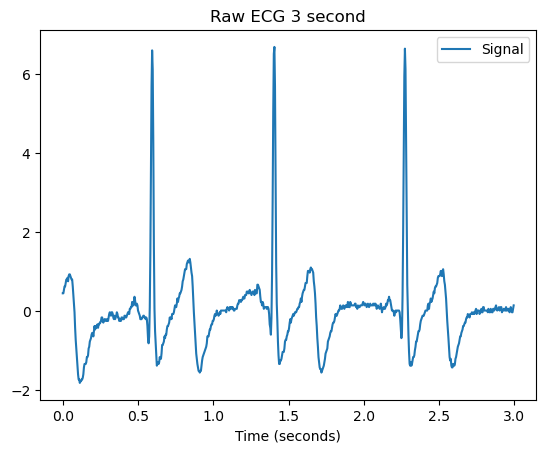

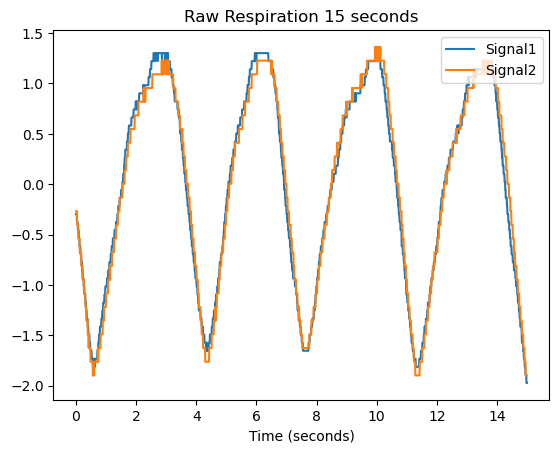

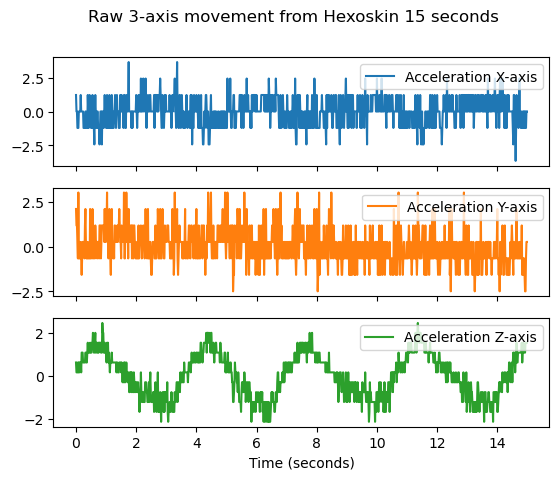

In [5]:
nk.signal_plot(ECG[460800:461568], sampling_rate=256, standardize=True) # ~ 3 second window -AJS
plt.title("Raw ECG 3 second")
nk.signal_plot([RespT[230400:232320], RespA[230400:232320]], sampling_rate=128, standardize=True) # ~ 15 second window -AJS
plt.title("Raw Respiration 15 seconds")
nk.signal_plot([AccX[115200:116160], AccY[115200:116160], AccZ[115200:116160]], sampling_rate=64,
               subplots=True, standardize=True,
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle("Raw 3-axis movement from Hexoskin 15 seconds");

## ECG Preprocessing
<details>
  <summary><h3>ECG Filtering and Cleaning Methods</h3></summary>

The following methods are available for ECG signal preprocessing:

*   **`'neurokit'` (default):**
    *   Applies a 0.5 Hz high-pass Butterworth filter (order = 5).
    *   Followed by powerline filtering. By default, the powerline frequency is 50 Hz.

*   **`'biosppy'`:**
    *   Employs the filtering method used in the BioSPPy package.
    *   A Finite Impulse Response (FIR) filter is applied with a passband of [0.67, 45] Hz.
    *   The filter order is set to 1.5 times the sampling rate (SR).
    *   The 0.67 Hz cutoff was chosen based on the fact that no morphological features exist below the heart rate (assuming a minimum heart rate of 40 bpm).

*   **`'pantompkins1985'`:**
    *   Implements the algorithm described by <a href='https://en.wikipedia.org/wiki/Pan%E2%80%93Tompkins_algorithm'>Pan & Tompkins (1985).</a>

*   **`'hamilton2002'`:**
    *   Implements the QRS detection preprocessing method described by Hamilton (2002).
    *   First, the ECG signal passes through a bandpass filter implemented by cascading a 15-sample low pass moving average filter (approximately 16 Hz) with a 7-sample high-pass moving average filter (approximately 8 Hz).
    *   The signal is then rectified (absolute value).
    *    Next, the signal is processed by an 80ms moving average filter.
    *   The algorithm does not explicitly implement a powerline frequency filter.   

*   **`'elgendi2010'`:**
    *   Implements the filtering approach used by Elgendi et al. (2010).
    *   Employs a second-order Butterworth bandpass filter.
    *   The study recommends a bandpass frequency range of 8-20 Hz for QRS detection.
    *   This approach focuses on filtering the signal to optimize the extraction of QRS components.
    *   The filter is then used as a stage of a QRS detection algorithm that uses moving averages, and an amplitude threshold, to identify the location of the QRS complex.

*   **`'engzeemod2012'`:**
    *  Implements the method described in Engelse & Zeelenberg (1979).
    *   **Description Required**: Please contribute a better description of this method!

*   **`'vg'`:**
    *   Applies the method used in Visibility Graph Based Detection as described in Emrich et al. (2023) and Koka et al. (2022).
    *   A 4.0 Hz high-pass Butterworth filter of order 2 is used.

</details>

<details>
    <summary><h3>References</h3></summary>

*   Engelse, W. A., & Zeelenberg, C. (1979). A single scan algorithm for QRS-detection and feature extraction. *Computers in cardiology, 6*(1979), 37-42.
*   Pan, J., & Tompkins, W. J. (1985). A real-time QRS detection algorithm. *IEEE transactions on biomedical engineering*(3), 230-236.
*   Hamilton, P. (2002). Open source ECG analysis. In *Computers in cardiology* (pp. 101-104). IEEE.
*   Elgendi, M., Jonkman, M., & De Boer, F. (2010). Frequency Bands Effects on QRS Detection. *Biosignals, Proceedings of the Third International Conference on Bio-inspired Systems and Signal Processing*, 428-431.
*   Emrich, J., Koka, T., Wirth, S., & Muma, M. (2023), Accelerated Sample-Accurate R-Peak Detectors Based on Visibility Graphs. *31st European Signal Processing Conference (EUSIPCO),* 1090-1094, doi: 10.23919/EUSIPCO58844.2023.10290007

</details>

ecg_cleaned = nk.ecg_clean(ECG, sampling_rate=256, method='neurokit')
#ecg_cleaned1 = nk.ecg_clean(ECG, sampling_rate=256, method='biosppy')
#ecg_cleaned2 = nk.ecg_clean(ECG, sampling_rate=256, method='pantompkins1985')
#ecg_cleaned3 = nk.ecg_clean(ECG, sampling_rate=256, method='hamilton2002')
#ecg_cleaned4 = nk.ecg_clean(ECG, sampling_rate=256, method='elgendi2010')
#ecg_cleaned5 = nk.ecg_clean(ECG, sampling_rate=256, method='engzeemod2012')
#ecg_cleaned6 = nk.ecg_clean(ECG, sampling_rate=256, method='vg')
#nk.signal_plot([ecg_cleaned0[460800:461568], ecg_cleaned1[460800:461568], ecg_cleaned2[460800:461568], ecg_cleaned3[460800:461568], ecg_cleaned4[460800:461568], ecg_cleaned5[460800:461568], ecg_cleaned6[460800:461568]], sampling_rate=256, subplots=True, labels=['neurokit', 'biosspy', 'pantompkins', 'hamilton', ' elgendi', 'engzeemod', 'vg'], standardize=False)
nk.signal_plot([ecg_cleaned[460800:461568], ECG[460800:461568]], sampling_rate=256, subplots=False, labels=['ecg cleaned', 'ecg raw'], standardize=True)
plt.title("Filtered ECG compared to Raw ECG");

### ECG Quality Assessment

<details>
  <summary><h3>Quality Assertions</h3></summary>

The following methods are available for ECG signal quality measurement:

*   **`'averageQRS'`**
    *   Computes a continuous quality index for the ECG signal.
    *   This index reflects how similar each QRS complex (heartbeat) is to the average QRS complex in the signal.
    *   A value of 1 indicates a heartbeat that closely matches the average, while 0 represents a heartbeat that is very different from the average.
    *   **Important**: A value of 1 does not guarantee good signal quality; it only indicates similarity to the average. If most heartbeats are noisy or distorted, the "average" may also be poor. Use this index with care and plot it alongside your ECG signal to see if it makes sense.

*   **`'zhao2018'`**
    *   Extracts several Signal Quality Indices (SQIs) to assess ECG quality based on the work of Zhao et al. (2018).
    *   Returns  `'Unacceptable'`, `'Barely Acceptable'` or `'Excellent'`
    *   The following indices are extracted:
        *   **pSQI**: Measures the power spectrum distribution of the QRS wave, reflecting the energy content in that portion of the signal.
        *   **kSQI**: Measures the kurtosis of the signal, which indicates how peaked or flat the signal's distribution is, and can detect abnormal signal patterns.
        *   **basSQI**: Measures the relative power of the baseline, which indicates the amount of baseline drift or low-frequency noise present in the signal.
    *   **Note:** This implementation does not include the R-peak detection matching index (qSQI) used in the original paper. The weights for combining the SQIs have been adjusted to [0.6, 0.2, 0.2] for pSQI, kSQI, and basSQI, respectively.
    
</details>

<details>
    <summary><h3>References</h3></summary>

*   Zhao, Z., & Zhang, Y. (2018). "SQI quality evaluation mechanism of single-lead ECG signal based on simple heuristic fusion and fuzzy comprehensive evaluation". *Frontiers in Physiology*, *9*, 727.

</details>

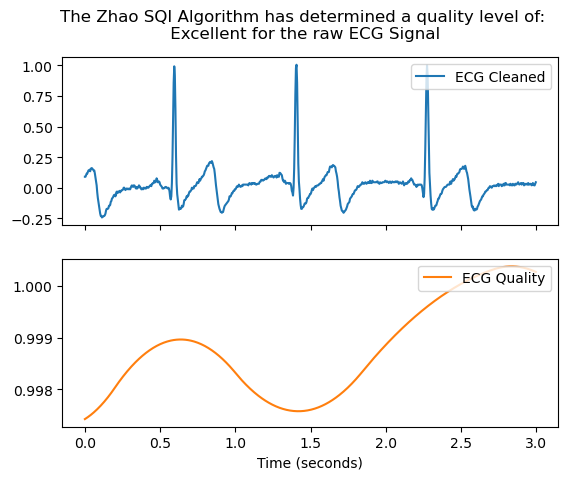

In [6]:
ecg_quality = nk.ecg_quality(ECG, sampling_rate=256, method="averageQRS")

nk.signal_plot(
    [ECG[460800:461568], ecg_quality[460800:461568]],
    sampling_rate=256,
    subplots=True,
    labels=["ECG Cleaned", "ECG Quality"],
    standardize=False
)
plt.suptitle(f"The Zhao SQI Algorithm has determined a quality level of:\n {nk.ecg_quality(ECG, sampling_rate=256, method='zhao2018', approach='fuzzy')} for the raw ECG Signal");

## Respiration Preprocessing
<details>
  <summary><h3>Respiration Filtering Methods</h3></summary>

The following methods are available for ECG signal preprocessing:

*   **`'khodadad2018'` (default):**
    *   Applies a second order 0.05-3 Hz bandpass Butterworth filter.

*   **`'biosppy'`:**
    *    Applies a second order 0.1-0.35 Hz bandpass Butterworth filter followed by a constant
      detrending).

*   **`'hampel'`:**
    *   Applies a median-based Hampel filter by replacing values which are 3 (can be changed via ``threshold``) away from the rolling median.

</details>

<details>
    <summary><h3>References</h3></summary>

* Khodadad, D., Nordebo, S., Müller, B., Waldmann, A., Yerworth, R., Becher, T., ... & Bayford,
      R. (2018). Optimized breath detection algorithm in electrical impedance tomography.
      Physiological measurement, 39(9), 094001.
* Power, J., Lynch, C., Dubin, M., Silver, B., Martin, A., Jones, R.,(2020)
      Characteristics of respiratory measures in young adults scanned at rest,
      including systematic changes and “missed” deep breaths.
      NeuroImage, Volume 204, 116234

</details>

In [7]:
Resp = 13.28 * ((0.75 * RespT) + (0.25 * RespA))

#resp_cleaned = nk.rsp_clean(Resp, sampling_rate=128, method="khodadad2018")
#rsp_cleaned1 = nk.rsp_clean(Resp, sampling_rate=128, method="biosppy")
#rsp_cleaned2 = nk.rsp_clean(Resp, sampling_rate=128, method="hampel", threshold=3)
#nk.signal_plot([rsp_cleaned0[230400:232320], rsp_cleaned1[230400:232320], rsp_cleaned2[230400:232320]], sampling_rate=128, standardize=True, subplots=False)
#nk.signal_plot([Resp[230400:232320], resp_cleaned[230400:232320]], sampling_rate=128, standardize=True)
#plt.suptitle("Respiration From Hexoskin");

## Hexoskin Motion Preprocessing

<details>
  <summary><h3>Motion Filtering Methods</h3></summary>

The following methods are used for motion signal preprocessing:

*   **Bandpass Filtering of Acceleration Axes (X, Y, Z):**
    *   Applies a 3rd order Butterworth bandpass filter with a passband of 0.25-0.5 Hz to each of the acceleration axes (`AccX`, `AccY`, `AccZ`).
    *   This filtering is designed to isolate the frequency range of interest that is associated with slow, intentional movement, and reject higher frequencies associated with noise and fast movement.
*   **Magnitude Calculation:**
    *   The filtered acceleration axes (`AccX_filt`, `AccY_filt`, `AccZ_filt`) are used to calculate the magnitude of the 3D acceleration vector (`ACC_Hex`).
    * This is done by taking the square root of the sum of the squares of the filtered acceleration signals.
*   **Lowpass Filtering of Magnitude:**
    *   Applies a 3rd order Butterworth low-pass filter with a high-cut frequency of 0.5 Hz to the acceleration magnitude (`ACC_Hex`).
    *   This second filtering step is used to further smooth the data, and to remove any remaining high-frequency noise.

</details>

<details>
    <summary><h3>References</h3></summary>

*   Butterworth, S. (1930). On the Theory of Filter Amplifiers. *Wireless Engineer*, *7*(12), 536-541.
*   Winter, D. A. (2009). *Biomechanics and motor control of human movement*. John Wiley & Sons.

</details>

In [8]:
#AccX_filt = nk.signal_filter(AccX, sampling_rate=64, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#AccY_filt = nk.signal_filter(AccY, sampling_rate=64, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#AccZ_filt = nk.signal_filter(AccZ, sampling_rate=64, lowcut=0.25, highcut=0.5, method='butterworth', order=3)

#nk.signal_plot([AccX[115200:116160], AccX_filt[115200:116160]], sampling_rate=64,
#               subplots=False, standardize=True,
#               labels=["Raw X-axis", "Filtered X-axis"])

ACC_Hex = np.sqrt((AccX**2) + (AccY**2) + (AccZ**2)) # magnitude calculation

#ACC_Hex_clean = nk.signal_filter(ACC_Hex, sampling_rate=64, highcut=0.5, method='butterworth', order=3)
#nk.signal_plot([ACC_Hex[115200:116160], ACC_Hex_clean[115200:116160]], sampling_rate=64, labels=['Raw Motion', 'Filtered Motion'], standardize=True)
#plt.suptitle("Motion from Hexoskin");

## Hexoskin Resampling

<details>
  <summary><h3>Resampling Methods</h3></summary>

The following methods are used for resampling (upsampling) the respiration and motion signals to match the sampling rate of the ECG signal which is our highest resolution.

*   **Resampling Methods:**
    The following methods for signal resampling can be chosen.

*   `'interpolation'`:
           *  Uses linear interpolation (`scipy.ndimage.zoom()`) to resample the signal.  This is the fastest method.

*   `'FFT'`:
            * Uses the Fourier method (`scipy.signal.resample()`) to resample the signal in the frequency domain. It is the most accurate method (for periodic signals) but it is slow for longer signals.

*   `'poly'`:
            * Uses polyphase filtering (`scipy.signal.resample_poly()`) to resample the signal.

*   `'numpy'`:
            * Uses numpy's interpolation method (`np.interp()`).

*   `'pandas'`:
            * Uses pandas's time series resampling to resample the signal.

</details>

<details>
    <summary><h3>References</h3></summary>

*   Smith, S. W. (1997). *The scientist and engineer's guide to digital signal processing*. California Technical Pub.
*  <a href='https://www.pearson.com/en-us/subject-catalog/p/discrete-time-signal-processing/P200000007840/9780131988422'>Oppenheim, A. V., & Schafer, R. W. (2014). *Discrete-time signal processing*. Pearson.</a>

</details>

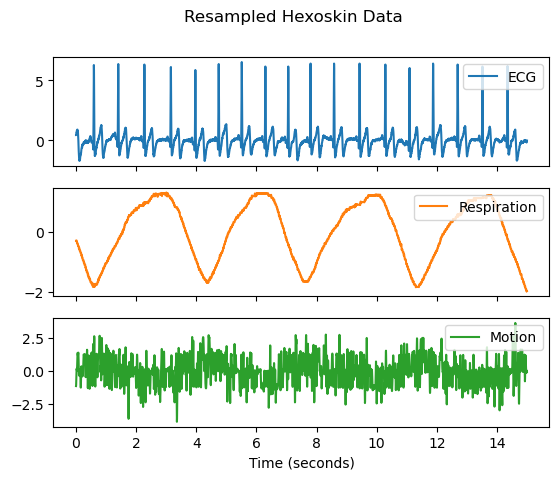

In [9]:
# just in case we need to downsample instead later.... -AJS
TARGET_SAMPLE_RATE = 256
fs = TARGET_SAMPLE_RATE
ecg_up = nk.signal_resample(ECG, sampling_rate=256, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT') # already 256 -AJS

RespT_up = nk.signal_resample(RespT, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
RespA_up = nk.signal_resample(RespA, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')
Resp_up = nk.signal_resample(Resp, desired_length=len(ECG), sampling_rate=128, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

hex_accx_up = nk.signal_resample(AccX, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accy_up = nk.signal_resample(AccY, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_accz_up = nk.signal_resample(AccZ, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='numpy')
hex_motion_up = nk.signal_resample(ACC_Hex, desired_length=len(ECG), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

nk.signal_plot([ecg_up[460800:464640], Resp_up[460800:464640], hex_motion_up[460800:464640]], sampling_rate=256, subplots=True, standardize=True, labels=['ECG', 'Respiration', 'Motion'])
plt.suptitle("Resampled Hexoskin Data");

In [10]:
hexo_np = np.column_stack([ecg_up, RespT_up, RespA_up, Resp_up, hex_accx_up, hex_accy_up, hex_accz_up, hex_motion_up])

time_index_hexo = pd.date_range(
    start=startTime_hexo,
    periods=len(hexo_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_hexo = pd.DataFrame(
    hexo_np,
    index=time_index_hexo,
    columns=["ECG","Thoratic Respiration", "Abdominal Respiration", "Combined Respiration", "ACC X", "ACC Y", "ACC Z", "Hexoskin Motion"]
)

display(comb_hexo.head())

,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion
2024-10-15 17:21:31+00:00,8.947237,1.256280e-11,5.153971e-12,1.937893e-10,-0.515672,-0.226609,-0.527390,0.771628
2024-10-15 17:21:31.003906250+00:00,17.504031,-4.758496e+02,-3.012196e+02,-5.739511e+03,-0.468797,-0.209031,-0.511765,0.810174
2024-10-15 17:21:31.007812500+00:00,17.504031,2.119571e-11,1.059785e-11,1.025640e-10,-0.421922,-0.191453,-0.496140,0.763289
2024-10-15 17:21:31.011718750+00:00,17.504031,7.505359e+02,4.675440e+02,9.027583e+03,-0.375047,-0.173875,-0.480515,0.672684
2024-10-15 17:21:31.015625+00:00,17.504031,2.660738e-11,8.793963e-12,4.571572e-10,-0.328172,-0.156297,-0.464890,0.590126


# Load E4 Data

### Helper Functions
Loads the data from the E4 CSV's into the notebook environment

In [11]:
BVPe4   = os.path.join(dataDirectory, "BVP.csv")
EDAe4   = os.path.join(dataDirectory, "EDA.csv")
ACCe4   = os.path.join(dataDirectory, "ACC.csv")
Tempe4  = os.path.join(dataDirectory, "TEMP.csv")
IBI_path = os.path.join(dataDirectory, "IBI.csv") # might need this later -AJS   
    
BVP_raw = read_e4_csv(BVPe4, ['bvp']) # 64 Hz
EDA_raw = read_e4_csv(EDAe4, ['eda']) # 4 Hz
ACC_raw = read_e4_csv(ACCe4, ['acc_x', 'acc_y', 'acc_z']) # 32 Hz
Temp_raw = read_e4_csv(Tempe4, ['temp']) # 64 Hz
IBIe4 = read_ibi_file(IBI_path) # peak to peak distances from e4 precalced, scaled * 1000


startTime_E4 = BVP_raw.index[0]

# Periods = ["traintest", "rest1", "test1", "rest2", "test2", "rest3", "test3"]

## Initial Inspection of E4 Data

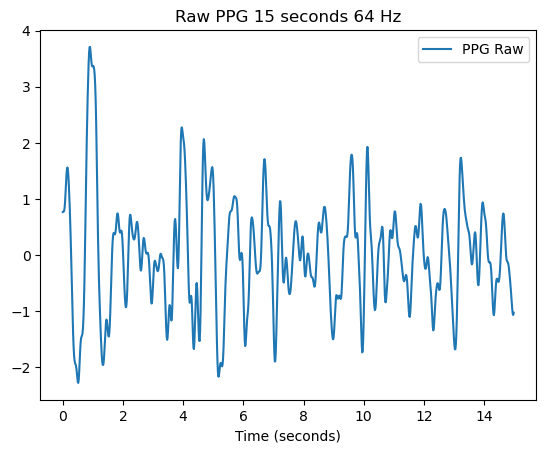

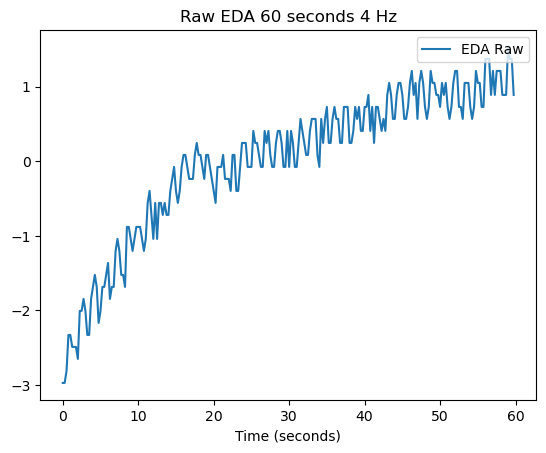

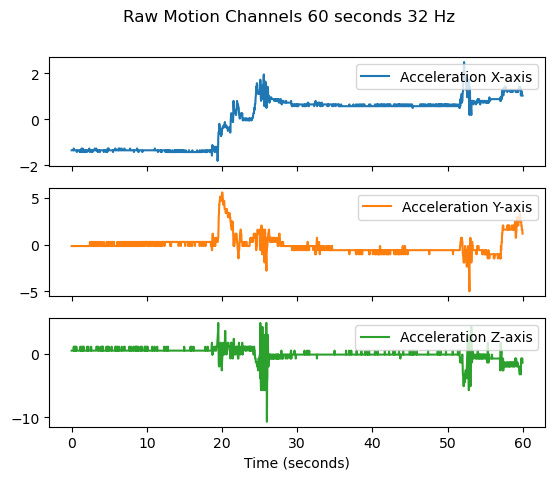

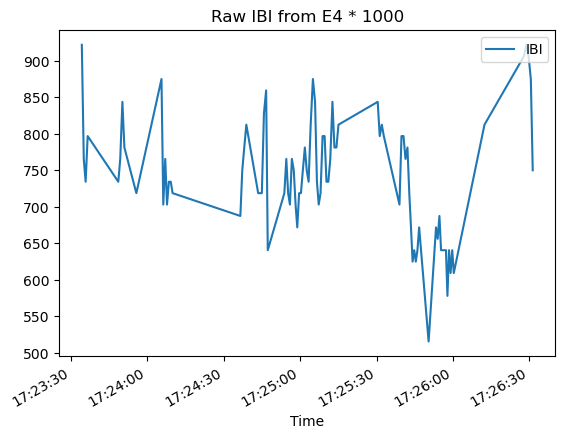

In [31]:
BVP = BVP_raw['bvp'].values
EDA = EDA_raw['eda'].values
acc_x = ACC_raw['acc_x'].values
acc_y = ACC_raw['acc_y'].values
acc_z = ACC_raw['acc_z'].values
Temp = Temp_raw['temp'].values

nk.signal_plot(BVP[115200:116160], sampling_rate=64, standardize=True, labels=['PPG Raw']) # ~ 15 second window -AJS
plt.title("Raw PPG 15 seconds 64 Hz")
nk.signal_plot(EDA[7200:7440], sampling_rate=4, standardize=True, labels=['EDA Raw']) # ~ 60 second window -AJS
plt.title("Raw EDA 60 seconds 4 Hz")
nk.signal_plot([acc_x[57600:59520], acc_y[57600:59520], acc_z[57600:59520]], sampling_rate=32,
               subplots=True, standardize=True, 
               labels=["Acceleration X-axis", "Acceleration Y-axis", "Acceleration Z-axis"]) # ~ 15 second window -AJS
plt.suptitle('Raw Motion Channels 60 seconds 32 Hz');
nk.signal_plot(IBIe4[10:100], labels=['IBI'])
plt.title("Raw IBI from E4 * 1000");

## PPG Preprocessing

<details>
  <summary><h3>PPG Cleaning Methods</h3></summary>

The following methods are available for cleaning a photoplethysmogram (PPG) signal:

*   **`'elgendi'` (default):**
    *   Applies a processing pipeline to prepare a raw PPG signal for systolic peak detection.
    *   **Description Required**: Please contribute a better description of this method!

*  **`'nabian2018'`:**
    *   Applies a processing pipeline described by Nabian et al. (2018).
    *   Requires the heart rate of the PPG signal as input to check if the filter frequency is appropriate.

*   **`'none'`:**
     *   Returns the raw signal without any cleaning.

</details>

<details>
    <summary><h3>References</h3></summary>

*   Nabian, M., Yin, Y., Wormwood, J., Quigley, K. S., Barrett, L. F., & Ostadabbas, S. (2018).
    An open-source feature extraction tool for the analysis of peripheral physiological data.
    *IEEE Journal of Translational Engineering in Health and Medicine*, *6*, 1-11.

</details>

In [13]:
#ppg_clean = nk.ppg_clean(BVP, sampling_rate=64, method='elgendi')
    
#nk.signal_plot([BVP[115200:116160], ppg_clean[115200:116160]], sampling_rate=64, standardize=True, labels=['raw ppg', 'elgendi filtered'])

## EDA Preprocessing

<details>
  <summary><h3>EDA Cleaning </h3></summary>
  * None since sampling frequency is so low.
</details>

<details>
    <summary><h3>References</h3></summary>
    *   **No references specified in `nk.eda_clean` documentation**
</details>


In [14]:
# eda_clean = EDA

## E4 Motion Preprocessing
<details>
  <summary><h3>Motion Filtering Methods</h3></summary>

The following methods are used for motion signal preprocessing:

*   **Bandpass Filtering of Acceleration Axes (X, Y, Z):**
    *   Applies a 3rd order Butterworth bandpass filter with a passband of 0.25-0.5 Hz to each of the acceleration axes (`AccX`, `AccY`, `AccZ`).
    *   This filtering is designed to isolate the frequency range of interest that is associated with slow, intentional movement, and reject higher frequencies associated with noise and fast movement.
*   **Magnitude Calculation:**
    *   The filtered acceleration axes (`AccX_filt`, `AccY_filt`, `AccZ_filt`) are used to calculate the magnitude of the 3D acceleration vector (`ACC_Hex`).
    * This is done by taking the square root of the sum of the squares of the filtered acceleration signals.
*   **Lowpass Filtering of Magnitude:**
    *   Applies a 3rd order Butterworth low-pass filter with a high-cut frequency of 0.5 Hz to the acceleration magnitude (`ACC_Hex`).
    *   This second filtering step is used to further smooth the data, and to remove any remaining high-frequency noise.

</details>

<details>
    <summary><h3>References</h3></summary>

*   Butterworth, S. (1930). On the Theory of Filter Amplifiers. *Wireless Engineer*, *7*(12), 536-541.
*   Winter, D. A. (2009). *Biomechanics and motor control of human movement*. John Wiley & Sons.

</details>

In [15]:
#acc_x_filt = nk.signal_filter(acc_x, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#acc_y_filt = nk.signal_filter(acc_y, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)
#acc_z_filt = nk.signal_filter(acc_z, sampling_rate=32, lowcut=0.25, highcut=0.5, method='butterworth', order=3)

#nk.signal_plot([acc_x[57600:59520], acc_x_filt[57600:59520]], sampling_rate=32,
#               subplots=False, standardize=True,
#               labels=["Raw X-axis", "Filtered X-axis"])

ACC_E4_raw = np.sqrt((acc_x**2) + (acc_y**2) + (acc_z**2)) # magnitude calculation

# ACC_E4_clean = nk.signal_filter(ACC_E4, sampling_rate=32, highcut=0.5, method='butterworth', order=3)
#nk.signal_plot([ACC_E4[57600:59520], ACC_E4_clean[57600:59520]], sampling_rate=32, labels=['Raw E4 Motion', 'Filtered E4 Motion'], standardize=True)
# plt.suptitle("Motion from E4");

Resample E4 signals to 256
BVP => 64->256 => factor=4, EDA => 4->256 =>64, ACC =>32->256 =>8, Temp =>4->256 =>64

In [16]:
ppg_up = nk.signal_resample(BVP, sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='FFT')

#time_bvp = np.arange(len(BVP)) / 64
#time_ppg = np.arange(len(ppg_up)) / 256

#plt.figure()
#plt.plot(time_bvp, BVP, label='Original PPG')
#plt.plot(time_ppg, ppg_up, label='Resampled')
#plt.legend()
#plt.show
eda_up = nk.signal_resample(EDA, desired_length=len(ppg_up), sampling_rate=4, desired_sampling_rate=TARGET_SAMPLE_RATE, method='poly')

#time_eda = np.arange(len(EDA)) / 4
#time_eda_up = np.arange(len(eda_up)) / 256

#plt.figure()
#plt.plot(time_eda, EDA, label='original eda')
#plt.plot(time_eda_up, eda_up, label='upsampled eda')
#plt.legend()
#plt.show


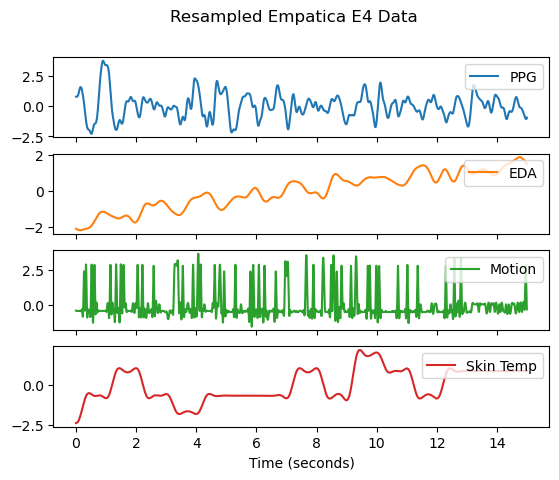

In [17]:

e4_accx_up = nk.signal_resample(acc_x, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_accy_up = nk.signal_resample(acc_y, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_accz_up = nk.signal_resample(acc_z, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')
e4_motion_up = nk.signal_resample(ACC_E4_raw, desired_length=len(ppg_up), sampling_rate=32, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')

temp_up = nk.signal_resample(Temp, desired_length=len(ppg_up), sampling_rate=64, desired_sampling_rate=TARGET_SAMPLE_RATE, method='interpolate')

nk.signal_plot([ppg_up[460800:464640], eda_up[460800:464640], e4_motion_up[460800:464640], temp_up[460800:464640]], sampling_rate=256, subplots=True, standardize=True, labels=['PPG', 'EDA', 'Motion', 'Skin Temp'])
plt.suptitle("Resampled Empatica E4 Data");

In [18]:
e4_np = np.column_stack([ppg_up, eda_up, e4_accx_up, e4_accy_up, e4_accz_up, e4_motion_up, temp_up])

time_index_e4 = pd.date_range(
    start=startTime_E4,
    periods=len(e4_np),
    freq=pd.Timedelta(1/fs, unit='s')
)

comb_e4 = pd.DataFrame(
    e4_np,
    index=time_index_e4,
    columns=["PPG", "EDA", "E4 ACC X", "E4 ACC Y", "E4 ACC Z", "Motion E4", "Skin Temp"]
)

# Data Alignment

## Load Event Data File

In [19]:

time_data = load_event_data(events)
participant_events = select_participant(time_data, participant_id)
times, utc_times = time_extract(participant_events)


Participant Selected and loaded, converting to UTC for data synchronization...


In [20]:
utc_times_df = pd.DataFrame(utc_times)
start_time = pd.to_datetime(utc_times_df['survey_start'].iloc[0]).tz_localize('UTC')
end_time = pd.to_datetime(utc_times_df['recovery_end'].iloc[0]).tz_localize('UTC')

display(utc_times_df)
#display(comb_e4.head())
#display(comb_hexo.head())
#display(comb_e4.tail())
#display(comb_hexo.tail())

,participant_id,date,survey_start,survey_end,cycle_cal_start,cycle_cal_end,matb_train_start,matb_train_end,cycle_start,cycle_end,...,trial_2_end,recovery_start,recovery_end,debrief_start,debrief_end,arrival_time,start_time,end_time,experimental_time,total_time
0,9,10/15/2024,2024-10-15 17:28:00,2024-10-15 17:31:00,2024-10-15 17:33:00,2024-10-15 17:41:30,2024-10-15 17:46:05,2024-10-15 17:58:00,2024-10-15 17:58:30,2024-10-15 18:03:30,...,2024-10-15 19:02:28,2024-10-15 19:06:30,2024-10-15 19:21:30,2024-10-15 19:22:00,2024-10-15 19:25:00,2024-10-15 17:00:00,2024-10-15 17:15:00,2024-10-15 19:25:00,2:10:00,2:25:00


In [32]:

frequency = f"{1000000000 / 256}ns"
experiment_time_index = pd.date_range(start=start_time, end=end_time, freq=frequency)

aligned_e4 = comb_e4.reindex(experiment_time_index)
aligned_hexo = comb_hexo.reindex(experiment_time_index)
aligned_ibi = IBIe4.reindex(experiment_time_index)

combined_df = pd.concat([aligned_e4, aligned_hexo, aligned_ibi], axis=1)

display(combined_df.head())

,PPG,EDA,E4 ACC X,E4 ACC Y,E4 ACC Z,Motion E4,Skin Temp,ECG,Thoratic Respiration,Abdominal Respiration,Combined Respiration,ACC X,ACC Y,ACC Z,Hexoskin Motion,ibi
2024-10-15 17:28:00+00:00,3.090000,0.144655,8.0,-3.0,64.0,64.566591,34.47,0.012844,25521.000000,14010.000000,300702.360000,-1.007859,0.003859,-0.066453,1.010055,NaN
2024-10-15 17:28:00.003906250+00:00,3.273805,0.144747,8.0,-3.0,64.0,64.577639,34.47,0.006444,25521.038387,14010.272208,300703.646063,-1.007859,0.002883,-0.064500,1.011084,NaN
2024-10-15 17:28:00.007812500+00:00,3.462001,0.144827,8.0,-3.0,64.0,64.599166,34.47,0.019244,25521.000000,14010.000000,300702.360000,-1.007859,0.001906,-0.062547,1.011417,NaN
2024-10-15 17:28:00.011718750+00:00,3.651686,0.144904,8.0,-3.0,64.0,64.623536,34.47,0.012844,25521.426121,14009.811275,300705.977597,-1.007859,0.000930,-0.060594,1.010869,NaN
2024-10-15 17:28:00.015625+00:00,3.840000,0.144981,8.0,-3.0,64.0,64.643111,34.47,0.012844,25522.000000,14010.000000,300712.320000,-1.007859,-0.000047,-0.058641,1.009564,NaN


In [193]:
# Plotting Setup
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel() # Flatten axes array for easier iteration
fig.suptitle(f"Hexo E4 Data: Test Subject", color="blue")  # Example title

# Define the signals
signals = {
    0: {"label": "ECG", "columns": ["ECG"]},
    1: {"label": "PPG", "columns": ["PPG"]},
    2: {"label": "EDA", "columns": ["EDA"]},
    3: {"label": "Resp", "columns": ["Respiration"]},
    4: {"label": "Accel Hexoskin", "columns": ["Motion"]},
    5: {"label": "Accel E4", "columns": ["Motion E4"]}
}

# Plotting Loop
for i, ax in enumerate(axes):
    if i in signals:
        signal = signals[i]
        columns = signal["columns"]
        for column in columns:
             ax.plot(combined_df.index, combined_df[column], label=column)
        ax.legend(loc='upper right')
        ax.set_title(signal["label"])

# Add Vertical lines for Events
timing_exp = combined_df["Event"].dropna().index
for ax in axes:
    for tstamp in timing_exp:
        ax.axvline(tstamp, color='r', linestyle='--')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
ecg = Synched_data_global.ECG
ppg = Synched_data_global.BVP
eda = Synched_data_global.EDA


ecg_signals, ecg_info = nk.ecg_process(ecg, sampling_rate=256)
nk.ecg_plot(ecg_signals[:3000], ecg_info)
ppg_signals, ppg_info = nk.ppg_process(ppg, sampling_rate=256)
nk.ppg_plot(ppg_signals[:3000], ppg_info)
eda_signals, eda_info = nk.eda_process(eda, sampling_rate=256)
nk.eda_plot(eda_signals[:3000], eda_info)

raw_resp_signal = chest + abdom
raw_resp_signal = raw_resp_signal * 13.28

rsp_signals, rsp_info = nk.rsp_process(raw_resp_signal, sampling_rate=256)
nk.rsp_plot(rsp_signals[:3000], rsp_info)

In [ ]:
fs = 256

# 1) Build a DataFrame of your signals. E.g.:
df_signals = pd.DataFrame({
    "ECG": ecg_signals["ECG_Clean"],  # Clean ECG from your pipeline
    "BVP": ppg_signals["PPG_Clean"],  # Clean PPG
    "EDA": eda_signals["EDA_Clean"],  # Clean EDA
    "RSP": rsp_signals["RSP_Clean"]   # Clean respiration
}, index=ecg_signals.index)

# 2) Create 60-second epochs.
epochs = nk.epochs_create(data=df_signals, sampling_rate=fs, epochs_end=60)

# Example subset to visualize a couple of epochs
subset_labels = sorted(epochs.keys())[3:5]
subset_epochs = {label: epochs[label] for label in subset_labels}
nk.epochs_plot(subset_epochs, columns=["ECG", "BVP", "EDA", "RSP"], legend=False)

# 3) For each epoch, compute your 8 vital metrics
hrv_data = []
all_epoch_labels = sorted(epochs.keys())
phasic_signal = eda_signals["EDA_Phasic"]

# 4) Compute phasic mean or average amplitude
phasic_mean = phasic_signal.mean()

# 5) Peak-to-peak amplitude of phasic? One approach is:
phasic_peak_to_peak = phasic_signal.max() - phasic_signal.min()

# Then store them in your row:
row["Phasic_Mean"] = phasic_mean
row["Phasic_Peak2Peak"] = phasic_peak_to_peak

for i, label in enumerate(all_epoch_labels):
    this_epoch = epochs[label]
    
    ecg_chunk = this_epoch["ECG"].values
    ecg_chunk_signals, ecg_chunk_info = nk.ecg_process(ecg_chunk, sampling_rate=fs)
    eda_chunk = this_epoch["EDA"].values
    eda_epoch_signals, eda_epoch_info = nk.eda_process(eda_chunk, sampling_rate=fs)
    eda_phasic = eda_epoch_signals["EDA_Phasic"]
    phasic_mean = eda_phasic.mean()
    phasic_peak_to_peak = eda_phasic.max() - eda_phasic.min()

     # Metric 1: Mean HR from continuous
    HR_mean = hr_continuous.mean()
    # Metric 2: Max HR
    HR_max  = hr_continuous.max()

    # Gather rpeaks to compute time/freq domain HRV metrics
    rpeaks = ecg_chunk_info["ECG_R_Peaks"]

    if len(rpeaks) > 1:
        # Metric 3: Average IBI (in sec)
        r_diffs_sec = np.diff(rpeaks) / fs
        IBI = r_diffs_sec.mean()
    else:
        IBI = np.nan

    # 4) Use NeuroKit's built-in *time-domain* HRV function
    #    => returns a dictionary of standard measures (e.g. RMSSD, etc.)
    hrv_time_dict = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
    RMSSD = hrv_time_dict.get("HRV_RMSSD", np.nan)

    # 5) Use NeuroKit's *frequency-domain* HRV function
    #    => returns a dictionary with HF, LF, etc.
    hrv_freq_dict = nk.hrv_frequency(rpeaks, sampling_rate=fs, show=False)
    HRV_HF = hrv_freq_dict.get("HRV_HF", np.nan)

    # 6) Instead of hrv_nonlinear, we compute Sample Entropy ourselves
    #    => This is your "ECG_SampEn" or "HRV_SampEn"
    #    => Typically use dimension=2 and delay=1 if uncertain
    if len(r_diffs_sec) > 4:  # must have enough intervals
        sampEn, _ = nk.entropy_sample(r_diffs_sec, dimension=2, delay=1)
    else:
        sampEn = np.nan


    row = {
        "Epoch_index": i,
        "Label": label,
        "HR_MEAN": HR_mean,
        "HR_MAX": HR_max,
        "IBI": IBI,
        "RMSSD": RMSSD,
        "HRV_HF": HRV_HF,
        "ECG_SampEn": sampEn,
        "Phasic_Mean": phasic_mean,
        "Phasic_Peak2Peak": phasic_peak_to_peak
    }
    hrv_data.append(row)


# 7) Convert to DataFrame
df_hrv_features = pd.DataFrame(hrv_data)
events = nk.events_create(
    event_onsets=[epoch * fs for epoch in range(len(all_epoch_labels))],
    event_durations=[fs * 60] * len(all_epoch_labels),
    event_labels=[f"Epoch {i}" for i in range(len(all_epoch_labels))]
)
nk.events_plot(events, df_signals["ECG"].values)

In [ ]:
def compute_dtw(epochs):
    distances = []
    for i in range(len(epochs) - 1):
        dist = dtw.distance(epochs[i], epochs[i + 1])
        distances.append(dist)
    return distances

# Sampling rate
fs = 256

# Example data structure (replace these variables with your actual data)
df_signals = pd.DataFrame({
    "ECG": ecg_signals["ECG_Clean"],  # Replace with your ECG clean signal
    "BVP": ppg_signals["PPG_Clean"],  # Replace with your PPG clean signal
    "EDA": eda_signals["EDA_Clean"],  # Replace with your EDA clean signal
    "RSP": rsp_signals["RSP_Clean"]   # Replace with your respiration clean signal
}, index=ecg_signals.index)

# Create 60-second epochs
epochs = nk.epochs_create(data=df_signals, sampling_rate=fs, epochs_end=60)

# Visualize a subset of epochs
subset_labels = sorted(epochs.keys())[3:5]
subset_epochs = {label: epochs[label] for label in subset_labels}
nk.epochs_plot(subset_epochs, columns=["ECG", "BVP", "EDA", "RSP"], legend=False)

# Process each epoch to extract HRV and other metrics
hrv_data = []
all_epoch_labels = sorted(epochs.keys())

for i, label in enumerate(all_epoch_labels):
    this_epoch = epochs[label]

    # Process ECG signal
    ecg_chunk = this_epoch["ECG"].values
    ecg_chunk_signals, ecg_chunk_info = nk.ecg_process(ecg_chunk, sampling_rate=fs)

    # Process EDA signal
    eda_chunk = this_epoch["EDA"].values
    eda_epoch_signals, eda_epoch_info = nk.eda_process(eda_chunk, sampling_rate=fs)
    eda_phasic = eda_epoch_signals["EDA_Phasic"]

    # Extract HRV metrics
    rpeaks = ecg_chunk_info["ECG_R_Peaks"]
    if len(rpeaks) > 1:
        rr_intervals = np.diff(rpeaks) / fs  # Convert to seconds
        hr_values = 60 / rr_intervals  # Instantaneous heart rate in bpm
        HR_mean = np.mean(hr_values) if len(hr_values) > 0 else np.nan
        HR_max = np.max(hr_values) if len(hr_values) > 0 else np.nan
    else:
        HR_mean, HR_max = np.nan, np.nan

    hrv_time_dict = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
    hrv_freq_dict = nk.hrv_frequency(rpeaks, sampling_rate=fs, show=False)

    row = {
        "Epoch_index": i,
        "Label": label,
        "HR_MEAN": HR_mean,
        "HR_MAX": HR_max,
        "IBI": rr_intervals.mean() if len(rr_intervals) > 0 else np.nan,
        "RMSSD": hrv_time_dict.get("HRV_RMSSD", np.nan),
        "HRV_HF": hrv_freq_dict.get("HRV_HF", np.nan),
        "ECG_SampEn": nk.entropy_sample(rr_intervals, dimension=2, delay=1)[0] if len(rr_intervals) > 4 else np.nan,
        "Phasic_Mean": eda_phasic.mean(),
        "Phasic_Peak2Peak": eda_phasic.max() - eda_phasic.min()
    }

    hrv_data.append(row)

# Convert HRV data to DataFrame
df_hrv_features = pd.DataFrame(hrv_data)

# Ensure the data is cleaned and properly formatted
data = df_hrv_features["HR_MEAN"].dropna().values
data = data[np.isfinite(data)]
data = data.reshape(-1, 1)

# Perform change point detection with adjusted truncate value
Q_full, P_full, Pcp_full = offline_changepoint_detection(
    data,
    prior_function=partial(const_prior, p=1 / (len(data) + 1)),
    FullCovarianceLikelihood(),
    truncate=-50
)

# Plot change point probabilities
fig, ax = plt.subplots(2, figsize=[18, 8])
ax[0].plot(data, label='HR_MEAN')
ax[0].set_title("HR Mean with Detected Change Points")
for change in np.where(np.exp(Pcp_full).sum(0) > 0.5)[0]:
    ax[0].axvline(change, color='red', linestyle='--', label='Change Point')
ax[1].plot(np.exp(Pcp_full).sum(0), label='Change Point Probabilities')
ax[1].set_title("Change Point Probabilities")
plt.legend()
plt.show()


# Validate with DTW
epochs_dtw = [epochs[label]["ECG"].values for label in all_epoch_labels]
dtw_distances = compute_dtw(epochs_dtw)
print("DTW Distances:", dtw_distances)

# Create events for visualization
events = nk.events_create(
    event_onsets=[epoch * fs for epoch in range(len(all_epoch_labels))],
    event_durations=[fs * 60] * len(all_epoch_labels),
    event_labels=[f"Epoch {i}" for i in range(len(all_epoch_labels))]
)
nk.events_plot(events, df_signals["ECG"].values)
